# Reproducing eigenvalue study

### Empirical network

- Explain cutoff line powerlaw - irreducible Perron-Frobenius?
- Sample ranks
- Variance behavior?

Empirical z between 0.03 and 0.3

In [1]:
import numpy as np
import scipy
from src import renormalizable_model
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

In [2]:
weighted_adj_matrix = np.loadtxt(open("data/fg_empiricalNTW(node_num=1000).csv", "rb"), delimiter=",").reshape((1000,1000))

In [3]:
strength_data = np.loadtxt(open("data/fg_strengths(node_num=1000).csv", "rb"), delimiter=",")

In [4]:
sampled_out_strengths, sampled_in_strengths, ext_equities = strength_data

In [5]:
out_strengths = np.sum(weighted_adj_matrix, axis=1)
in_strengths = np.sum(weighted_adj_matrix, axis=0)

In [6]:
equities = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(weighted_adj_matrix))])

In [7]:
leverage_matrix = weighted_adj_matrix/equities[:,None]

In [8]:
empirical_max_eigenvalue = np.max(np.abs(np.linalg.eigvals(leverage_matrix)))

In [9]:
print("Max eigenvalue of empirical network:", empirical_max_eigenvalue)

Max eigenvalue of empirical network: 0.05555555564559029


### Fully connected network

In [10]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)

In [11]:
fc_network = renormalizable_model.create_RM_graph(computed_strengths, z=np.infty, weighted=True)

In [12]:
fc_weighted_adj_matrix = np.array(fc_network.get_adjacency(attribute='weight').data)
fc_equities = np.array([np.sum(fc_weighted_adj_matrix[i,:]) - np.sum(fc_weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(fc_weighted_adj_matrix))])
fc_leverage_matrix = fc_weighted_adj_matrix/equities[:,None]

In [13]:
fc_max_eigenvalue = np.max(np.abs(np.linalg.eigvals(fc_leverage_matrix)))

In [14]:
print("Max eigenvalue of fully connected network:", empirical_max_eigenvalue)

Max eigenvalue of fully connected network: 0.05555555564559029


In [15]:
np.linalg.matrix_rank(fc_weighted_adj_matrix)

1

### Ensemble

In [16]:
num_of_links = np.sum(weighted_adj_matrix > 0)

In [17]:
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [18]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.019080723824060897


In [20]:
exp_z = exp_z_details.root

In [21]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)
ensemble_size = 100

In [22]:
z_values = np.logspace(-6,0,25,endpoint=True, base=10)

In [21]:
# ensembles = Parallel(n_jobs=cpu_count())(delayed(renormalizable_model.generate_RM_ensemble)(ensemble_size, computed_strengths, z, weighted=True)  for z in z_values)

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


In [23]:
ensembles = Parallel(n_jobs=cpu_count())(delayed(renormalizable_model.generate_RM_ensemble)(ensemble_size, computed_strengths, z, weighted=True, parallel=False)  for z in z_values)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [24]:
def compute_leverage_matrix(graph, ext_equities):
    weighted_adj_matrix = np.array(graph.get_adjacency(attribute='weight').data)
    equities = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(weighted_adj_matrix))])
    return weighted_adj_matrix/equities[:,None]

In [25]:
def compute_max_eigenvalue(matrix):
    return np.max(np.abs(np.linalg.eigvals(matrix)))

In [26]:
leverage_matrices = [Parallel(n_jobs=cpu_count())(delayed(compute_leverage_matrix)(graph, ext_equities) for graph in ensemble) for ensemble in tqdm(ensembles)]

100%|██████████| 25/25 [01:22<00:00,  3.29s/it]


In [27]:
max_eigenvalues = [Parallel(n_jobs=cpu_count())(delayed(compute_max_eigenvalue)(leverage_matrix) for leverage_matrix in leverage_matrices_z) for leverage_matrices_z in tqdm(leverage_matrices)]

100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


In [28]:
mean_max_eigenvalues = [np.mean(max_eigenvalues[i]) for i in range(len(z_values))]

In [29]:
%config InlineBackend.figure_format = "retina"

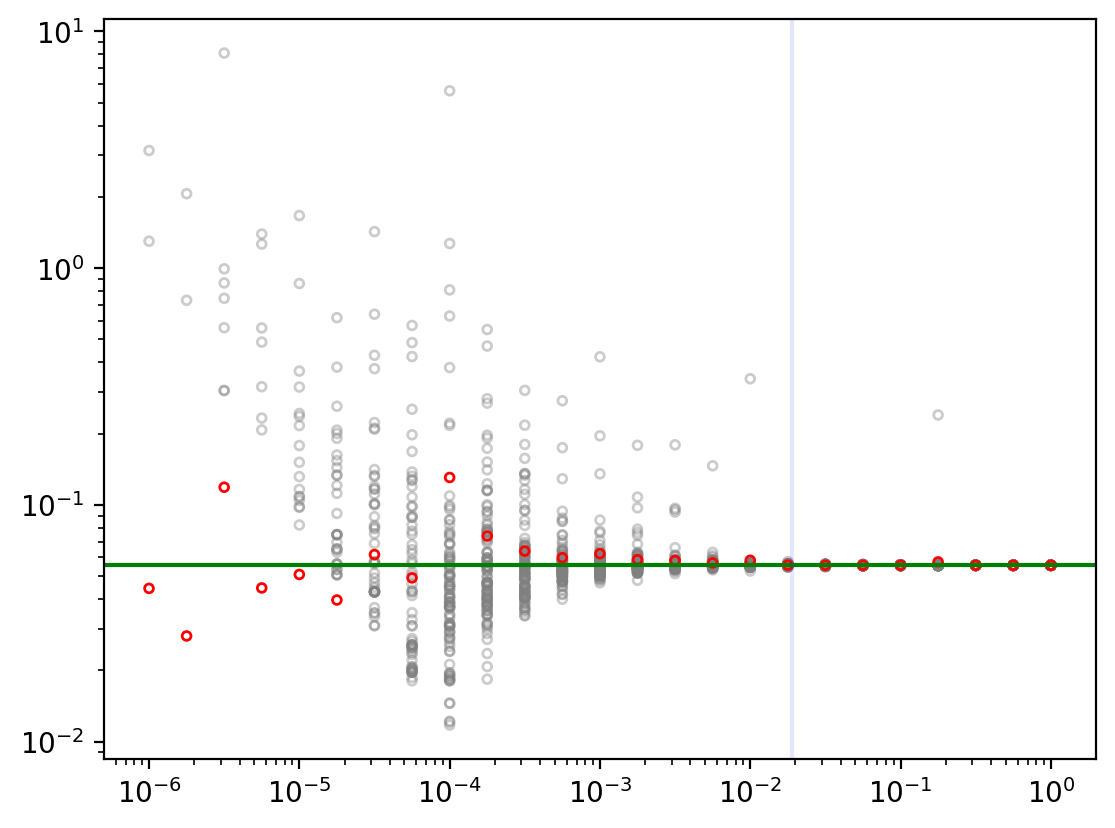

In [30]:
for i in range(len(z_values)):
    z_arr = z_values[i]*np.ones(len(max_eigenvalues[i]))
    plt.scatter(z_arr, max_eigenvalues[i], edgecolor='grey', facecolors='none', s=10, alpha=0.4)
plt.scatter(z_values, mean_max_eigenvalues, s=10, edgecolor='red', facecolors='none', alpha=1)
plt.axhline(y = empirical_max_eigenvalue, color = 'green', linestyle = '-') 
plt.axvline(x = exp_z, color = "blue", alpha=0.1)
plt.xscale("log")
plt.yscale("log")

### Experiments

Constant external equities

In [29]:
ext_equities_2 = np.ones(1000)

In [30]:
equities_2 = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities_2[i] for i in range(len(weighted_adj_matrix))])
emp_leverage_matrix_2 = weighted_adj_matrix/equities_2[:,None]
emp_max_eigenvalue_2 = compute_max_eigenvalue(emp_leverage_matrix_2)

In [31]:
print("Max eigenvalue of empirical netowrk:", emp_max_eigenvalue_2)

Max eigenvalue of empirical netowrk: 32.920349750280984


In [32]:
fc_leverage_matrix_2 = compute_leverage_matrix(fc_network, ext_equities_2)
fc_max_eigenvalue_2 = compute_max_eigenvalue(fc_leverage_matrix_2)

In [33]:
print("Max eigenvalue of fully connected network:", fc_max_eigenvalue_2)

Max eigenvalue of fully connected network: 18.67123194741742


In [34]:
leverage_matrices_2 = [Parallel(n_jobs=cpu_count())(delayed(compute_leverage_matrix)(graph, ext_equities_2) for graph in ensemble) for ensemble in tqdm(ensembles)]
max_eigenvalues_2 = [Parallel(n_jobs=cpu_count())(delayed(compute_max_eigenvalue)(leverage_matrix) for leverage_matrix in leverage_matrices_z) for leverage_matrices_z in tqdm(leverage_matrices_2)]

100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


In [35]:
mean_max_eigenvalues_2 = [np.mean(max_eigenvalues_2[i]) for i in range(len(z_values))]

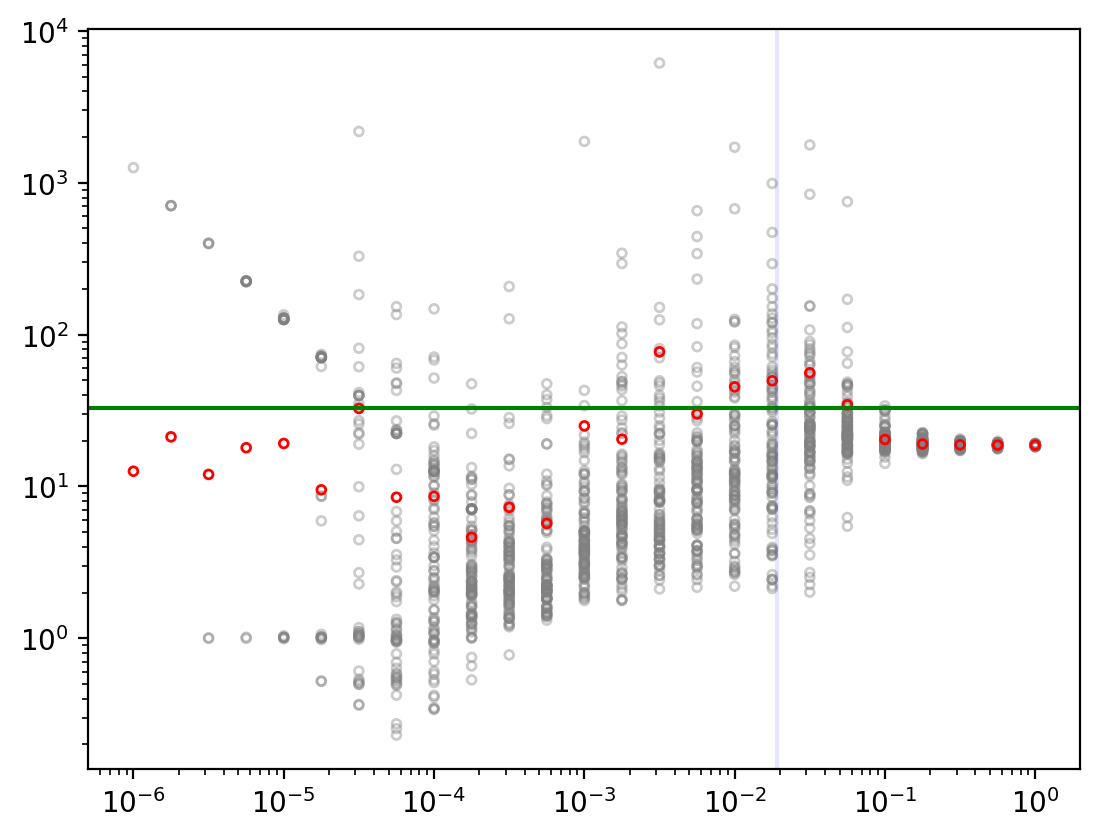

In [36]:
for i in range(len(z_values)):
    z_arr = z_values[i]*np.ones(len(max_eigenvalues[i]))
    plt.scatter(z_arr, max_eigenvalues_2[i], edgecolor='grey', facecolors='none', s=10, alpha=0.4)
plt.scatter(z_values, mean_max_eigenvalues_2, s=10, edgecolor='red', facecolors='none', alpha=1)
plt.axhline(y = emp_max_eigenvalue_2, color = 'green', linestyle = '-') 
plt.axvline(x = exp_z, color = "blue", alpha=0.1)
plt.xscale("log")
plt.yscale("log")

Different external equities

In [37]:
W = np.sum(weighted_adj_matrix)
lamda = 0.4
in_strength_0 = 20*W
out_strength_0 = lamda*in_strength_0

In [38]:
ext_equities_3 = [(out_strengths[i]*in_strength_0 - in_strengths[i]*out_strength_0)/W for i in range(len(out_strengths))]

In [39]:
equities_3 = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities_3[i] for i in range(len(weighted_adj_matrix))])
emp_leverage_matrix_3 = weighted_adj_matrix/equities_3[:,None]
emp_max_eigenvalue_3 = compute_max_eigenvalue(emp_leverage_matrix_3)

In [40]:
print("Max eigenvalue of empirical network:", emp_max_eigenvalue_3)

Max eigenvalue of empirical network: 0.08333333333333352


In [41]:
fc_leverage_matrix_3 = compute_leverage_matrix(fc_network, ext_equities_3)
fc_max_eigenvalue_3 = compute_max_eigenvalue(fc_leverage_matrix_3)

In [42]:
print("Max eigenvalue of fully connected network:", fc_max_eigenvalue_3)

Max eigenvalue of fully connected network: 0.08333333333333337


In [43]:
# leverage_matrices_3 = [Parallel(n_jobs=cpu_count())(delayed(compute_leverage_matrix)(graph, ext_equities_3) for graph in ensemble) for ensemble in tqdm(ensembles)]
# max_eigenvalues_3 = [Parallel(n_jobs=cpu_count())(delayed(compute_max_eigenvalue)(leverage_matrix) for leverage_matrix in leverage_matrices_z) for leverage_matrices_z in tqdm(leverage_matrices_3)]

In [44]:
# mean_max_eigenvalues_3 = [np.mean(max_eigenvalues_3[i]) for i in range(len(z_values))]

In [45]:
# for i in range(len(z_values)):
#     z_arr = z_values[i]*np.ones(len(max_eigenvalues_3[i]))
#     plt.scatter(z_arr, max_eigenvalues_3[i], edgecolor='grey', facecolors='none', s=10, alpha=0.4)
# plt.scatter(z_values, mean_max_eigenvalues_3, s=10, edgecolor='red', facecolors='none', alpha=1)
# plt.axhline(y = emp_max_eigenvalue_3, color = 'green', linestyle = '-') 
# plt.axvline(x = exp_z, color = "blue", alpha=0.1)
# plt.xscale("log")
# plt.yscale("log")

### Studying low-z cutoff

In [118]:
def compute_rank(matrix):
    symmetrized = matrix.T@matrix
    eigvals = np.linalg.eigvals(symmetrized)
    return symmetrized.shape[1] - np.sum(np.isclose(eigvals, 0))

In [162]:
eigv = np.array(max_eigenvalues[7])

In [163]:
eigv

array([0.02382654, 0.        , 0.01995573, 0.        , 0.12793311,
       0.06786828, 0.        , 0.        , 0.        , 0.        ,
       0.04138721, 0.        , 0.16803125, 0.02558364, 0.11964719,
       0.        , 0.48444006, 0.01805461, 0.02562942, 0.10789967,
       0.08847178, 0.57261425, 0.01865027, 0.0207121 , 0.        ,
       0.        , 0.05663839, 0.        , 0.01995774, 0.        ,
       0.        , 0.        , 0.0504906 , 0.        , 0.02203321,
       0.04292013, 0.03504208, 0.06224223, 0.08995348, 0.06465543,
       0.02034744, 0.02655735, 0.1976936 , 0.02436841, 0.02491805,
       0.        , 0.05196209, 0.02499043, 0.07506241, 0.01962423,
       0.        , 0.04632029, 0.        , 0.12660806, 0.0255895 ,
       0.01964453, 0.02556072, 0.09896629, 0.13771767, 0.13214869,
       0.01959779, 0.04291129, 0.02004723, 0.02334703, 0.        ,
       0.25325071, 0.02067319, 0.        , 0.03085597, 0.        ,
       0.        , 0.        , 0.        , 0.42311408, 0.07747

In [167]:
np.min(eigv[eigv>0])

0.01805460512197407

In [173]:
lowest_nonzero_eigenvalue_index = np.where(eigv == np.min(eigv[eigv>0]))[0][0]

In [263]:
lowest_nonzero_eigenvalue_index

17

In [275]:
lowest_lev_matrix = leverage_matrices[7][lowest_nonzero_eigenvalue_index]

In [277]:
compute_rank(lowest_lev_matrix)

25

In [187]:
np.where(np.diag(lowest_lev_matrix)>0)

(array([42]),)

In [202]:
lowest_lev_matrix[42,42]

0.01805460512197407

In [223]:
max(computed_strengths[:,0])

73.145271

In [224]:
computed_strengths[42]

array([73.145271, 73.145271])

Traces

In [135]:
np.trace(leverage_matrices[7][0])

0.023826535240256325

In [140]:
traces = np.trace(leverage_matrices[7], axis1=1, axis2=2)

In [142]:
traces

array([0.02382654, 0.        , 0.01995573, 0.        , 0.02497681,
       0.09285877, 0.        , 0.        , 0.        , 0.        ,
       0.01900731, 0.        , 0.16803125, 0.04488611, 0.        ,
       0.        , 0.50478251, 0.01805461, 0.02562942, 0.16143548,
       0.01929903, 0.        , 0.01865027, 0.0207121 , 0.        ,
       0.        , 0.05663839, 0.        , 0.01995774, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08683495, 0.05466845, 0.        , 0.12383353, 0.05008879,
       0.02034744, 0.        , 0.01966848, 0.02436841, 0.02491805,
       0.        , 0.07271955, 0.02499043, 0.09435187, 0.01962423,
       0.        , 0.0199989 , 0.        , 0.12660806, 0.0255895 ,
       0.01964453, 0.04590642, 0.09896629, 0.13771767, 0.19791129,
       0.01959779, 0.08942611, 0.02004723, 0.04298147, 0.        ,
       0.54990372, 0.02067319, 0.        , 0.03085597, 0.        ,
       0.        , 0.        , 0.        , 0.49189946, 0.04230

In [141]:
eigv == traces

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True])

In [128]:
m1 = leverage_matrices[7][1]
m2 = leverage_matrices[7][0]

In [133]:
np.trace(m1)

0.0

In [124]:
np.sum(m1)

11.925865552305295

In [125]:
compute_rank(m1)

25

In [129]:
np.sum(m2)

9.66165168313892

In [132]:
np.trace(m2)

0.023826535240256325

In [130]:
compute_rank(m2)

27

In [131]:
np.linalg.eigvals(m2)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02382654,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Studying ranks

In [112]:
def compute_rank(matrix):
    symmetrized = matrix.T@matrix
    eigvals = np.linalg.eigvals(symmetrized)
    return symmetrized.shape[1] - np.sum(np.isclose(eigvals, 0))

In [113]:
ranks = [Parallel(n_jobs=cpu_count())(delayed(compute_rank)(matrix) for matrix in tqdm(leverage_matrices_z)) for leverage_matrices_z in leverage_matrices]

100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


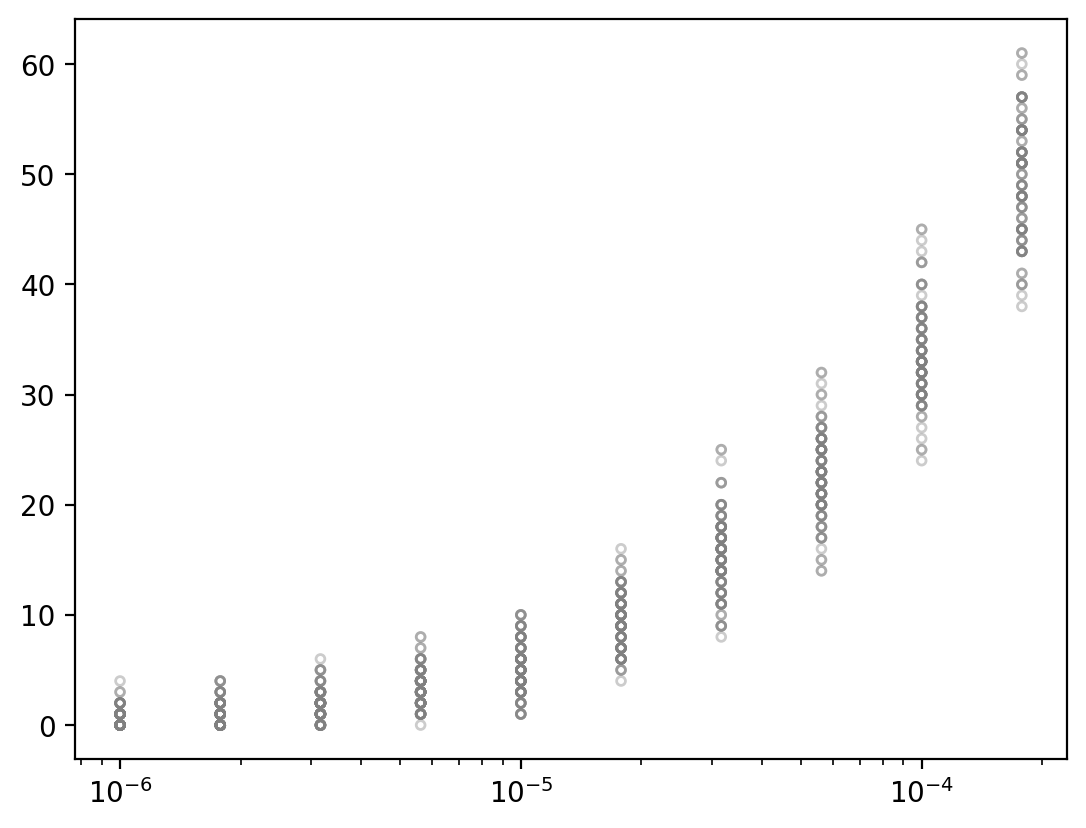

In [114]:
for i in range(10):
    z_arr = z_values[i]*np.ones(len(max_eigenvalues[i]))
    plt.scatter(z_arr, ranks[i], edgecolor='grey', facecolors='none', s=10, alpha=0.4)
# plt.scatter(z_values, mean_max_eigenvalues, s=10, edgecolor='red', facecolors='none', alpha=1)
# plt.axhline(y = empirical_max_eigenvalue, color = 'green', linestyle = '-') 
# plt.axvline(x = exp_z, color = "blue", alpha=0.1)
plt.xscale("log")

In [46]:
average_ranks = [np.mean([Parallel(n_jobs=cpu_count())(delayed(np.linalg.matrix_rank)(matrix) for matrix in leverage_matrices_z)]) for leverage_matrices_z in tqdm(leverage_matrices)]


100%|██████████| 25/25 [02:28<00:00,  5.96s/it]


In [47]:
normalized_average_ranks = np.array(average_ranks)/1000

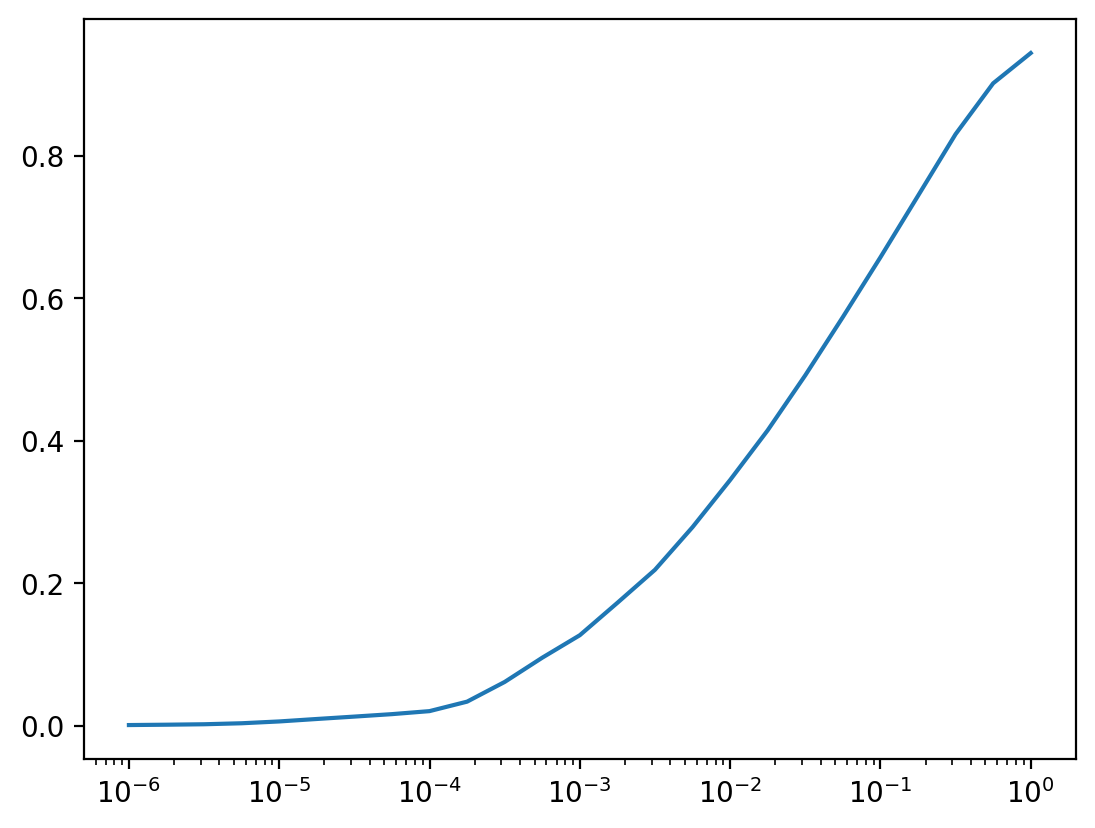

In [48]:
plt.plot(z_values, normalized_average_ranks)
plt.xscale("log")

In [49]:
eigvals_eigvectors = np.linalg.eig(fc_leverage_matrix)

In [ ]:
import scipy

In [ ]:
values, vectors = scipy.sparse.linalg.eigs(fc_leverage_matrix, k=1, sigma=1)

In [ ]:
values

array([0.05555556+0.j])

In [ ]:
normalized = vectors/vectors[0]

In [ ]:
np.allclose(normalized, 1, atol=1e-32)

True

In [ ]:
vectors[0] == vectors[1]

array([False])

In [ ]:
vectors[0]

array([0.03162278+0.j])

In [ ]:
vectors[1]

array([0.03162278+0.j])

In [ ]:
np.linalg.matrix_rank(leverage_matrix)

755

In [33]:
ensemble1 = renormalizable_model.generate_RM_ensemble(ensemble_size, computed_strengths, z=1e-4, weighted=True, parallel=False)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [39]:
ranks1 = [np.linalg.matrix_rank(np.array(graph.get_adjacency(attribute='weight').data)) for graph in tqdm(ensemble1)]

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


In [45]:
graph1 = ensemble1[1]
graph2 = ensemble1[2]

In [55]:
w_adj_matrix1 = graph1.get_adjacency(attribute='weight').data
w_adj_matrix2 = graph2.get_adjacency(attribute='weight').data

In [69]:
np.linalg.matrix_rank(w_adj_matrix1, tol=1e-10)

29

### Exact min max eigenvalue

In [228]:
max_self_strength = np.max(out_strengths*in_strengths)

In [229]:
max_self_strength

5350.230669663438

In [304]:
np.max(in_strengths)

73.14527099999997

In [248]:
max_self_strength_index = np.where(out_strengths*in_strengths == np.max(out_strengths*in_strengths))[0][0]

In [249]:
max_self_strength_index

42

In [269]:
gr = ensembles[7][17]

In [270]:
weighted_adj_matrix = np.array(gr.get_adjacency(attribute='weight').data)
equities = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(weighted_adj_matrix))])

In [300]:
corresp_in_strength = in_strengths[max_self_strength_index]
corresp_equity = ext_equities[max_self_strength_index]

In [301]:
corresp_equity

1316.61487582

In [271]:
equities[42]

1431.6135551883945

In [272]:
ext_equities[42]

1316.61487582

In [252]:
corresp_in_strength

73.14527099999997

In [253]:
corresp_equity

1316.61487582

In [234]:
W = np.sum(computed_strengths[:,0])

In [235]:
lamda = 0.1
y_0 = 20*W
x_0 = lamda*y_0

In [198]:
computed_strengths[42][0]*computed_strengths[42][1]

5350.230669663438

In [254]:
max_self_strength/((1 - np.exp(-z_values[7]*max_self_strength))*W*corresp_equity)

0.019631570249496088

In [255]:
max_self_strength/((1 - np.exp(-z_values[7]*max_self_strength))*W)

25.847217426191897

In [267]:
gr = ensembles[7][17]

In [268]:
gr.es[gr.get_eid(42,42)]["weight"]

25.847217426191897

In [200]:
x_i = computed_strengths[42][0]
y_j = computed_strengths[42][1]
p_ij = 1 - np.exp(-z_values[7]*x_i*y_j)

In [219]:
corresp_in_strength

1e-05

In [220]:
y_j

73.14527099999997

In [218]:
y_j/((1 - np.exp(-z_values[7]*x_i*y_j))*(y_0 - x_0))

0.019631570216990895

In [201]:
x_i*y_j/(p_ij*W)

25.847217426191897

In [193]:
computed_strengths

array([[0.046446, 0.046446],
       [0.339824, 0.339824],
       [0.356521, 0.356521],
       ...,
       [0.10125 , 0.10125 ],
       [0.040877, 0.040877],
       [0.10543 , 0.10543 ]])

In [194]:
np.sum(computed_strengths[:,0])

796.675667

In [236]:
min_max_eigenvalues = [corresp_in_strength/((1 - np.exp(-z*max_self_strength))*(y_0 - x_0)) for z in z_values]

In [279]:
min_max_eigenvalues_2 = [np.min([in_strengths[i]/((1 - np.exp(-z*out_strengths[i]*in_strengths[i]))*(y_0 - x_0)) for i in range(len(in_strengths))]) for z in z_values]

In [302]:
min_max_eigenvalues_3 = [max_self_strength/((1 - np.exp(-z*max_self_strength))*W*corresp_equity) for z in z_values]

In [303]:
min_max_eigenvalues_3

[0.9559187044584418,
 0.5386715452958836,
 0.3040383769948116,
 0.1720982771617342,
 0.097909711436394,
 0.05620251292992065,
 0.03277032768253643,
 0.019631570249496088,
 0.012310364495343241,
 0.008309974375237289,
 0.006252201557770696,
 0.005365561656287121,
 0.005125057299629022,
 0.005101104807786819,
 0.005100728595286733,
 0.005100728366284354,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917,
 0.005100728366283917]

In [280]:
min_max_eigenvalues_2

[0.9559187028756687,
 0.5386715444039722,
 0.3040383764913967,
 0.17209827687678056,
 0.0979097112742789,
 0.0562025128368627,
 0.0327703276282766,
 0.019631570216990895,
 0.012310364474960218,
 0.008309974361477956,
 0.006252201547418542,
 0.004667906672393423,
 0.0034867885451554583,
 0.0025945141423446747,
 0.0019463408001268014,
 0.0014703784164932152,
 0.0010928171623731068,
 0.0008202442356628184,
 0.0006144896032847955,
 0.000460817418551975,
 0.00034585127172259456,
 0.0002591631918113438,
 0.00019431569104850073,
 0.0001457164431344401,
 0.00010927271721291888]

In [237]:
min_max_eigenvalues

[0.9559187028756687,
 0.5386715444039722,
 0.3040383764913967,
 0.17209827687678056,
 0.0979097112742789,
 0.0562025128368627,
 0.0327703276282766,
 0.019631570216990895,
 0.012310364474960218,
 0.008309974361477956,
 0.006252201547418542,
 0.005365561647403031,
 0.005125057291143151,
 0.005101104799340607,
 0.005100728586841145,
 0.005100728357838767,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329,
 0.005100728357838329]

In [288]:
1/z_values

array([1.00000000e+06, 5.62341325e+05, 3.16227766e+05, 1.77827941e+05,
       1.00000000e+05, 5.62341325e+04, 3.16227766e+04, 1.77827941e+04,
       1.00000000e+04, 5.62341325e+03, 3.16227766e+03, 1.77827941e+03,
       1.00000000e+03, 5.62341325e+02, 3.16227766e+02, 1.77827941e+02,
       1.00000000e+02, 5.62341325e+01, 3.16227766e+01, 1.77827941e+01,
       1.00000000e+01, 5.62341325e+00, 3.16227766e+00, 1.77827941e+00,
       1.00000000e+00])

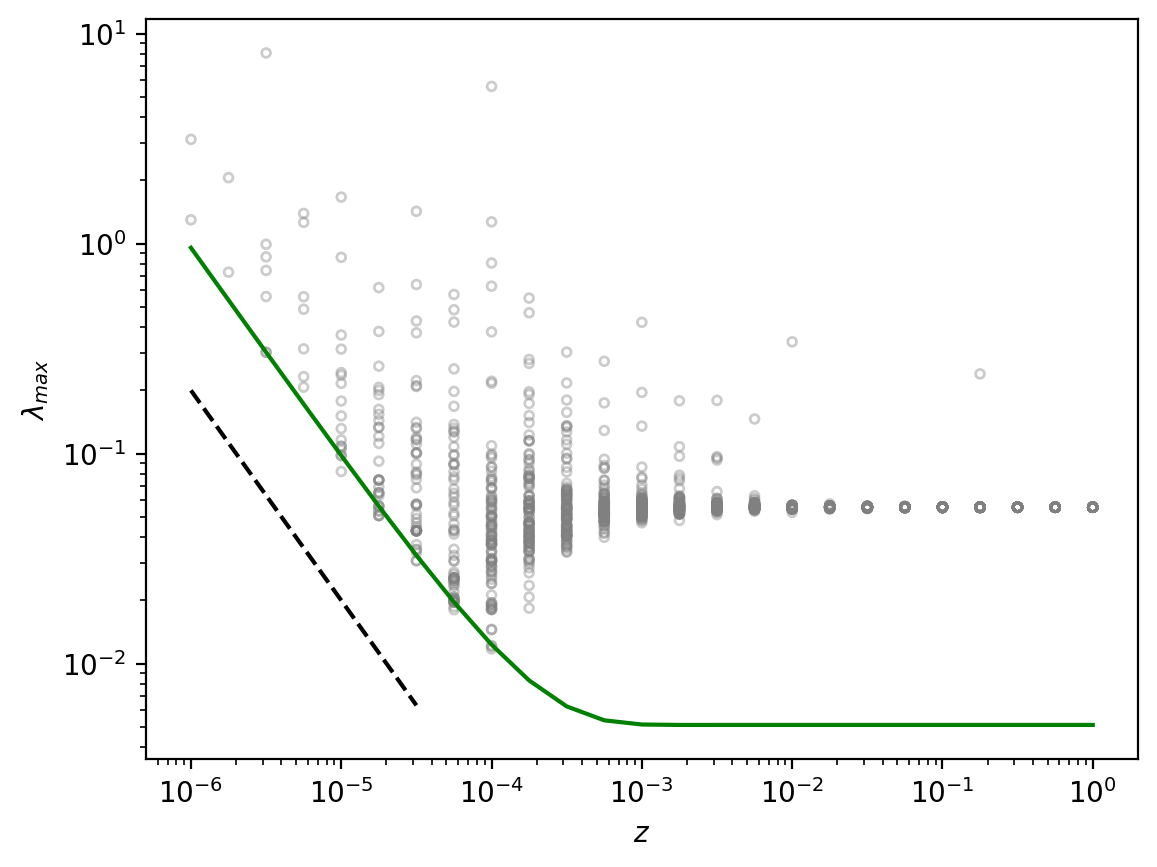

In [308]:
for i in range(len(z_values)):
    z_arr = z_values[i]*np.ones(len(max_eigenvalues[i]))
    plt.scatter(z_arr, max_eigenvalues[i], edgecolor='grey', facecolors='none', s=10, alpha=0.4)
#plt.scatter(z_values, mean_max_eigenvalues, s=10, edgecolor='red', facecolors='none', alpha=1)
#plt.scatter(z_values, min_max_eigenvalues, s=10, edgecolor='green', facecolors='none', alpha=1)
plt.plot(z_values, min_max_eigenvalues, color='green')
plt.plot(z_values[0:7], 1/(z_values[0:7]*1e6*5), 'k--')
#plt.axhline(y = empirical_max_eigenvalue, color = 'green', linestyle = '-') 
#plt.axvline(x = exp_z, color = "blue", alpha=0.1)
plt.xlabel(r"$z$")
plt.ylabel(r"$\lambda_{max}$")
plt.xscale("log")
plt.yscale("log")

In [241]:
np.sum(leverage_matrices[7][0]>0)

44